In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import seaborn as sns

sns.set()
sns.set_style("whitegrid")
color_palette = sns.color_palette('deep') + sns.color_palette('husl', 6) + sns.color_palette('bright') + sns.color_palette('pastel')

%matplotlib inline

## Multiple neurons with constant rate

Explore how many neurons we can model without much lagging:

- 1k-4k neurons
- 100Hz rate
    - or 1Hz for 10ms time unit
- ~2.5ms lag for an event

5.596242598948031

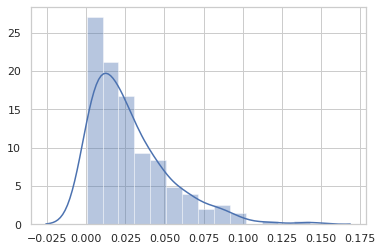

In [231]:
standard_rate = 40.
sim_n, spikes = 2_000, 200
scale = 1. / standard_rate
a = np.random.exponential(scale=scale, size=(spikes, sim_n)) + .01 * scale
sns.distplot(a[:, 0])

a[:, 0].sum()

In [232]:
%%time

import time
from queue import heappush, heappop

pq = list()
t0 = time.monotonic()

for t in range(sim_n):
    heappush(pq, (a[0, t] + t0, t))

i, i_spike = 1, [1]*sim_n
k = sim_n * spikes // 10
lag = .0
spin_cnt = 0

while len(pq):
    t = time.monotonic()
    if pq[0][0] <= t:
        ct, d = heappop(pq)
        cur_lag = t - ct
        lag += cur_lag
        
        if i_spike[d] < spikes:
            heappush(pq, (a[i_spike[d], d] + t, d))
            i_spike[d] += 1
            i += 1
            
#             if i % k == 0:
#                 print(t - t0, cur_lag * 1000., i, d)
    else:
        spin_cnt += 1
        
print(spin_cnt / 1000_000, lag * 1000. / (sim_n * spikes), lag * 100 / (sim_n * spikes) / scale)

10.825534 0.025924348217085936 0.10369739286834373
CPU times: user 6.2 s, sys: 3.94 ms, total: 6.21 s
Wall time: 6.21 s


## One neuron, non-constant rate

CPU times: user 82.9 ms, sys: 0 ns, total: 82.9 ms
Wall time: 87.9 ms


(51340, 10.00006579561159, 10.0)

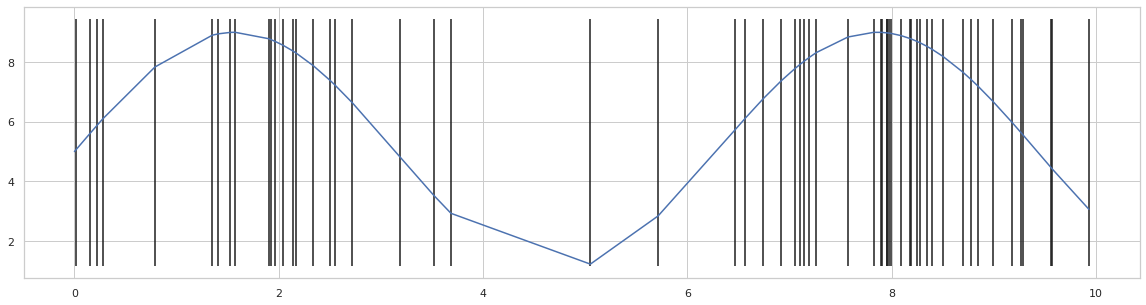

In [162]:
%%time

def rate_lambda(dT):
    return 5 + 4 * np.sin(dT)

def sample_spike_dt(dT):
    rate = rate_lambda(dT)
    scale = 1./rate
    spike_dt = np.random.exponential(scale=scale) + .01 * scale
    return spike_dt, rate

def scaled_time(T0, T):
    return (T - T0) / unit_of_time

unit_of_time = .005   # fraction of second
T0 = time.monotonic()
t, t_end = 0., 10.

ts, rates, spikes = [], [], []
next_spike_dt, cur_rate = sample_spike_dt(t)
next_spike_t = t + next_spike_dt

ts.append(t)
rates.append(cur_rate)

# print(t, next_spike_t)
j = 0

while t <= t_end:
    t = scaled_time(T0, time.monotonic())
    if t < next_spike_t:
        j += 1
        continue
    
    ts.append(t)
    spikes.append(t)
    
    next_spike_dt, cur_rate = sample_spike_dt(t)
    next_spike_t = t + next_spike_dt
    rates.append(cur_rate)
    
#     print(t, next_spike_t, next_spike_dt)

plt.figure(figsize=(20, 5))
sns.lineplot(ts, rates)

min_rates, max_rates = min(rates), max(rates)
plt.vlines(spikes, min_rates * .95, max_rates * 1.05)
# sns.scatterplot(spikes, rates[1:], marker='|', alpha=1.)

j, t, t_end

## Loading images from four-shapes kaggle dataset

In [712]:
import imageio
import os
from PIL import Image

four_shapes_dir = "./datasets/four_shapes/shapes"

def get_images(cnt, step=1, shape='triangle', start=600, size=10, normalized=True):
    cnt = int(cnt) # if cnt is float
    if not isinstance(size, tuple):
        size = (size, size)
    
    images = []        
    for i in range(cnt):
        ind = start + i * step
        img_path = os.path.join(four_shapes_dir, shape, f"{ind}.png")
        img = imageio.imread(img_path)
        resized_img = Image.fromarray(img).resize(size)
        img_arr = np.array(resized_img, dtype=np.float16) / 255. if normalized else np.array(resized_img)
        images.append(img_arr)
    return images

get_images(2, size=6)[0]

array([[1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.],
       [1., 1., 0., 0., 1., 1.],
       [1., 1., 0., 0., 1., 1.],
       [1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.]], dtype=float16)

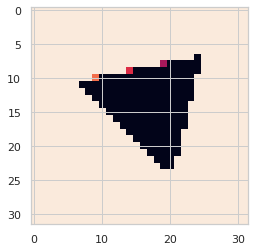

In [714]:
from IPython.display import clear_output

def slideshow_images(images, delay=.2):
    for img in images:
        clear_output()
        plt.imshow(img)
        plt.show()
        time.sleep(delay)
        
slideshow_images(get_images(30, step=4, size=32, normalized=False, shape='triangle'))

## One neuron, pixel based intensity from multiple images

CPU times: user 119 ms, sys: 12 µs, total: 119 ms
Wall time: 123 ms


(99586, 194, 15.00007698778063, 15.0)

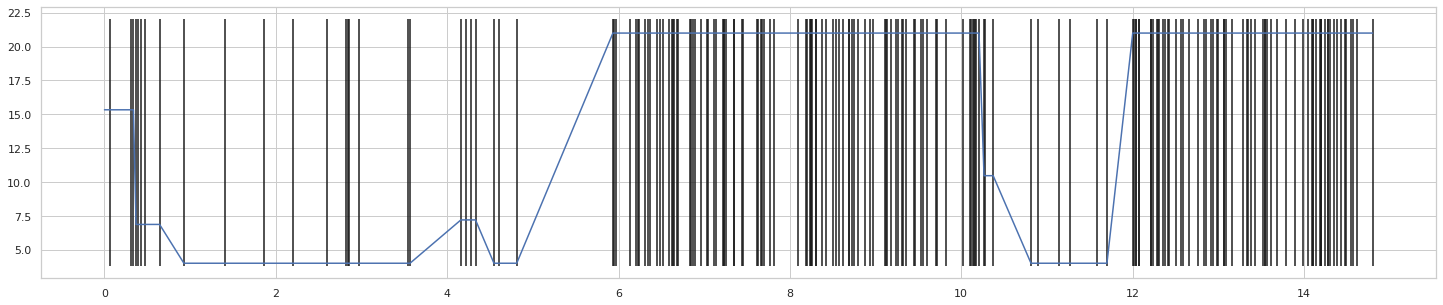

In [285]:
%%time

def rate_lambda(t):
    ind = min(int(t * len(small_images) / t_end), len(small_images) - 1)
    img = small_images[ind]
    return 4 + img[7][3] / 15

def sample_spike_dt(t, rate):
    scale = 1./rate
    spike_dt = np.random.exponential(scale=scale) + .01 * scale
    return spike_dt

def scaled_time(T0, T):
    return (T - T0) / unit_of_time

unit_of_time = .005   # fraction of second
T0 = time.monotonic()
t, t_end = 0., 15.

ts, rates, spikes = [], [], []
cur_rate = rate_lambda(t)
next_spike_dt = sample_spike_dt(t, cur_rate)
next_spike_t = t + next_spike_dt

ts.append(t)
rates.append(cur_rate)

# print(t, next_spike_t)
j = 0

while t <= t_end:
    t = scaled_time(T0, time.monotonic())
    if t < next_spike_t:
        j += 1
        continue
    
    ts.append(t)
    spikes.append(t)
    
    cur_rate = rate_lambda(t)
    next_spike_dt = sample_spike_dt(t, cur_rate)
    next_spike_t = t + next_spike_dt
    rates.append(cur_rate)
    
#     print(t, next_spike_t, next_spike_dt)

plt.figure(figsize=(25, 5))
sns.lineplot(ts, rates)

min_rates, max_rates = min(rates), max(rates)
plt.vlines(spikes, min_rates * .95, max_rates * 1.05)
j, len(ts), t, t_end

## Multiple neurons, images based intensity

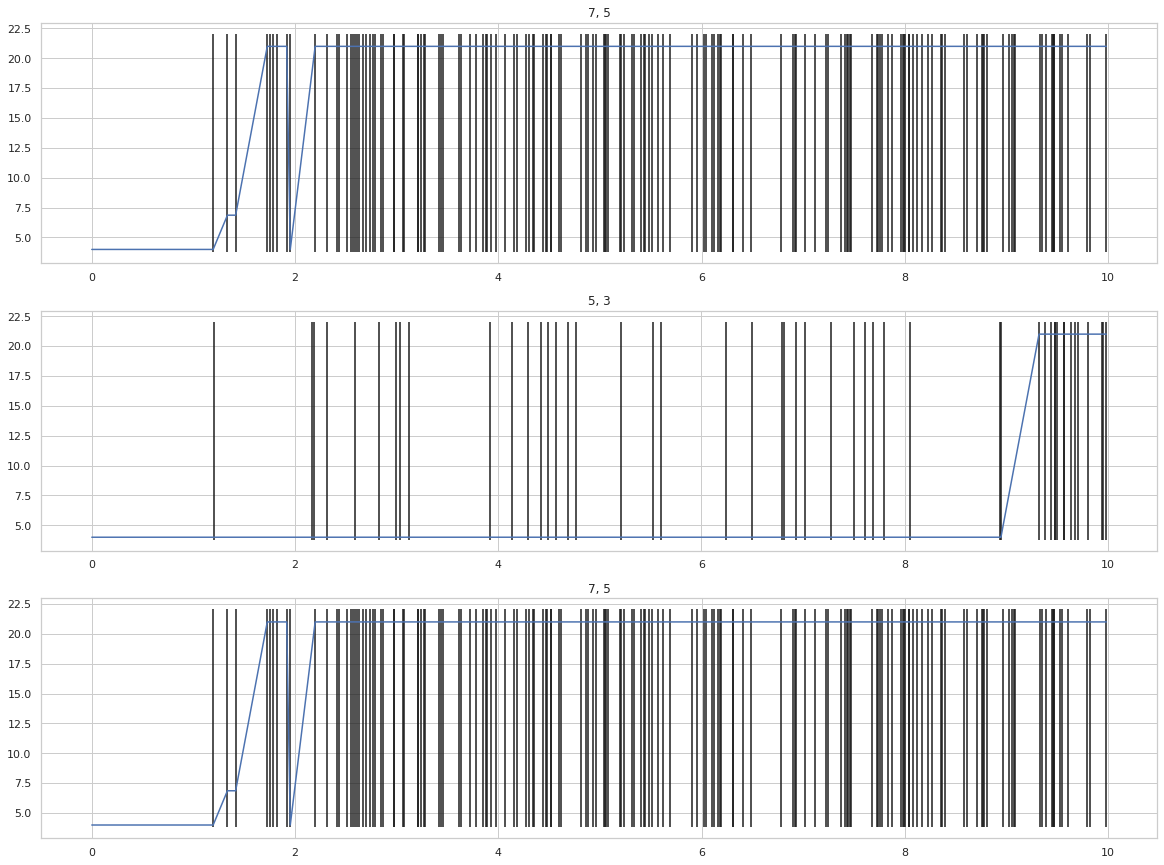

CPU times: user 1.1 s, sys: 0 ns, total: 1.1 s
Wall time: 1.11 s


(89341, 15031, 10.000211643055081, 10.0)

In [310]:
%%time

def rate_lambda(t, i, j):
    ind = min(int(t * len(small_images) / t_end), len(small_images) - 1)
    img = small_images[ind]
    return 4 + img[i][j] / pixel_scale

def save_events(ind, t, rate, t_spike=None):
    i, j = ind
    ts[i][j].append(t)
    rates[i][j].append(rate)
    if t_spike is not None:
        spikes[i][j].append(t_spike)
        
def recalculate_rate_next_spike(ind, t):
    i, j = ind
    rate = rate_lambda(t, i, j)
    next_spike_dt = sample_spike_dt(t, rate)
    next_spike_t = t + next_spike_dt
    return next_spike_t, rate


unit_of_time = .025   # fraction of second
pixel_scale = 15.
width, height = small_images[0].shape
T0 = time.monotonic()
t, t_end = 0., 10.

pq_times, ts, rates, spikes = [], [], [], []
for i in range(width):
    ts.append([]), rates.append([]), spikes.append([])
    for j in range(height):
        ts[i].append([]), rates[i].append([]), spikes[i].append([])
        
        ind = (i, j)
        next_spike_t, cur_rate = recalculate_rate_next_spike(ind, t)
        save_events(ind, t, cur_rate)
        heappush(pq_times, (next_spike_t, ind))

# print(t, next_spike_t)
j = 0

next_spike_t, ind = pq_times[0]
while t <= t_end:
    t = scaled_time(T0, time.monotonic())
    if t < next_spike_t:
        j += 1
        continue
    
    heappop(pq_times)
    next_spike_t, cur_rate = recalculate_rate_next_spike(ind, t)
    save_events(ind, t, cur_rate, t_spike=t)
    heappush(pq_times, (next_spike_t, ind))
    
    next_spike_t, ind = pq_times[0]

fig, axes = plt.subplots(3, 1, figsize=(20, 15))

for ax in axes:
    x, y = np.random.randint(0, 10, size=(2,))
    sns.lineplot(ts[x][y], rates[x][y], ax=ax)

    min_rates, max_rates = min(rates[x][y]), max(rates[x][y])
    ax.vlines(spikes[x][y], min_rates * .95, max_rates * 1.05)
    ax.set_title(f"{x}, {y}")

plt.show()
event_count = sum(len(a) for row in ts for a in row)
j, event_count, t, t_end

## Multiple neurons, images based intensity, no-fire updates

- clip long no-fire by `2*frame_dt`

In [405]:
def make_md_list(fn_elem_init, *args):
    if len(args) == 0:
        return fn_elem_init()
    return [make_md_list(fn_elem_init, *args[1:]) for _ in range(args[0])]

make_md_list(tuple, 3, 2)

[[(), ()], [(), ()], [(), ()]]

In [413]:
def iterate_flatten_dims(a, dims):
    return a if dims < 1 else (
        x
        for sub_a in a
        for x in iterate_flatten_dims(sub_a, dims - 1)
    )
#     return [make_md_list(fn_elem_init, *args[1:]) for _ in range(args[0])]

t = make_md_list(list, 3, 2, 1)
print(t)
print([x for x in iterate_flatten_dims(t, 1)])
print([x for x in iterate_flatten_dims(t, 2)])

[[[[]], [[]]], [[[]], [[]]], [[[]], [[]]]]
[[[]], [[]], [[]], [[]], [[]], [[]]]
[[], [], [], [], [], []]


In [660]:
def get_expected_spike_count():
    mean_fire_rate = np.mean(np.array(images))*white_rate + black_rate
    return mean_fire_rate * t_end * width * height

def get_expected_event_count():
    return n_frames * width * height

get_expected_event_count(), get_expected_spike_count()

(10000, 3210935.0)

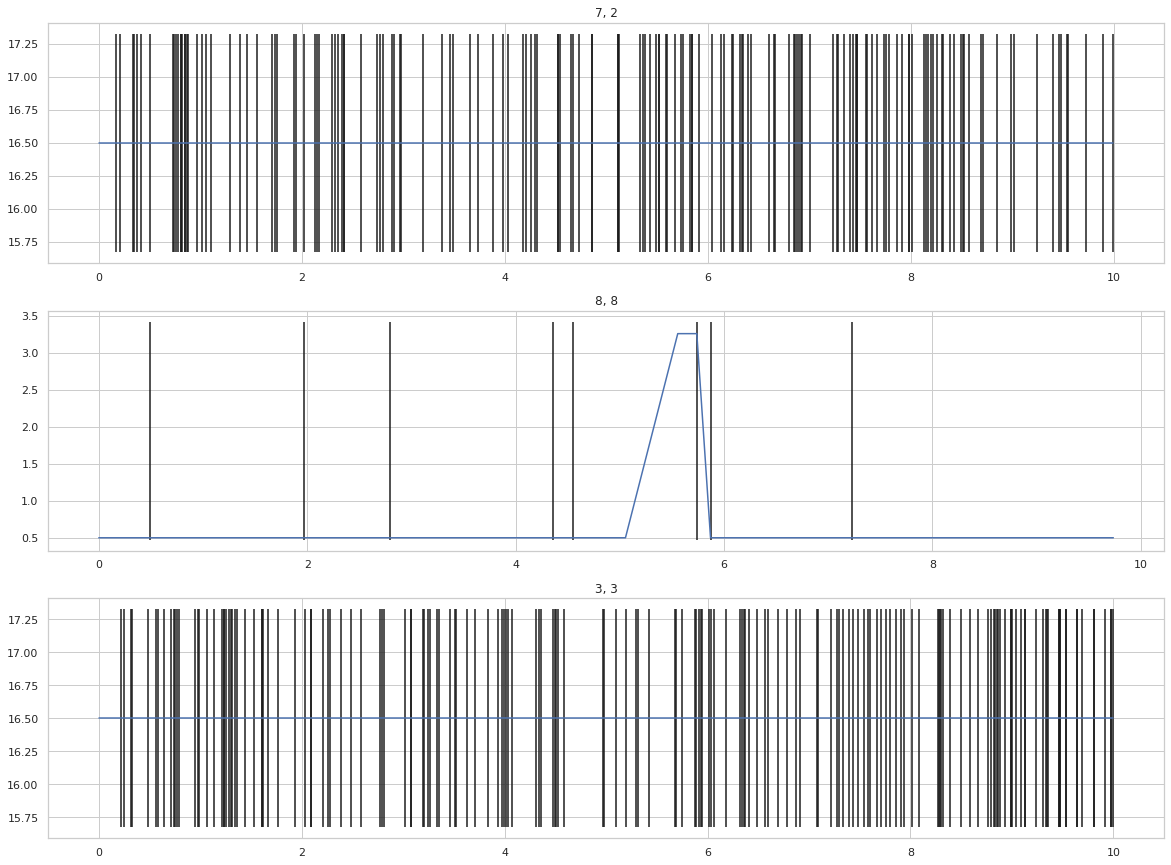

CPU times: user 2.21 s, sys: 6.68 ms, total: 2.22 s
Wall time: 2.23 s


(394089, 56780, 55984, 58656.25, 3.2670944220807936e-05)

In [729]:
%%time
from math import floor, ceil

def rate_lambda(t, i, j):
    ind = min(floor(t / frame_dt), n_frames - 1)
    pixel = images[ind][i][j]
    return black_rate + white_rate * pixel

def save_events(ind, t, rate, is_spike):
    i, j = ind
    ts[i][j].append(t)
    rates[i][j].append(rate)
    if is_spike:
        spikes[i][j].append(t)
        
def sample_spike_dt(t, rate):
    scale = 1./rate
    return np.random.exponential(scale=scale) + .01 * scale
        
def recalculate_neuron_state(ind, t, is_spike=False):
    i, j = ind
    rate = rate_lambda(t, i, j)
    save_events(ind, t, rate, is_spike)
    
    next_spike_dt = sample_spike_dt(t, rate)
    next_spike_t = t + min(next_spike_dt, max_no_fire_dt)
    will_spike = next_spike_dt < max_no_fire_dt
    
#     t_next_frame_update = ceil(t / frame_dt) * frame_dt
#     if next_spike_t > t_next_frame_update:
#         next_spike_t = t_next_frame_update
#         will_spike = False
    return next_spike_t, will_spike


unit_of_time = .1   # fraction of second
fpu = 4. # frames per unit of time
t, t_end = 0., 10.
n_frames = int(fpu * t_end)
black_rate, white_rate = .5, 16.
width, height = 20, 20
images = get_images(n_frames, step=2, shape='star', size=(width, height))
T0 = time.monotonic()
frame_dt = t_end / n_frames
max_no_fire_dt = frame_dt * 2

pq_times = []
ts, rates, spikes = [make_md_list(list, width, height) for _ in range(3)]
for i in range(width):
    for j in range(height):
        ind = (i, j)
        next_spike_t, is_spike = recalculate_neuron_state(ind, t)
        heappush(pq_times, (next_spike_t, is_spike, ind))

free_spin_count, lag = 0, 0.
next_spike_t, is_spike, ind = pq_times[0]
while t <= t_end:
    t = scaled_time(T0, time.monotonic())
    if t < next_spike_t:
        free_spin_count += 1
        continue
    
    lag += t - next_spike_t
    heappop(pq_times)
    next_spike_t, is_spike = recalculate_neuron_state(ind, t, is_spike)
    heappush(pq_times, (next_spike_t, is_spike, ind))
    
    next_spike_t, is_spike, ind = pq_times[0]

fig, axes = plt.subplots(3, 1, figsize=(20, 15))

for ax in axes:
    x, y = np.random.randint(0, 10, size=(2,))
    sns.lineplot(ts[x][y], rates[x][y], ax=ax)

    min_rates, max_rates = min(rates[x][y]), max(rates[x][y])
    ax.vlines(spikes[x][y], min_rates * .95, max_rates * 1.05)
    ax.set_title(f"{x}, {y}")

plt.show()
event_count = sum(map(len, iterate_flatten_dims(ts, 1))) - width * height
spikes_count = sum(map(len, iterate_flatten_dims(spikes, 1)))
lag_percent = 100 * (lag / event_count) / (event_count / t_end)
free_spin_count, event_count, spikes_count, get_expected_spike_count(), lag_percent

## Multiple neurons, difference based intensity

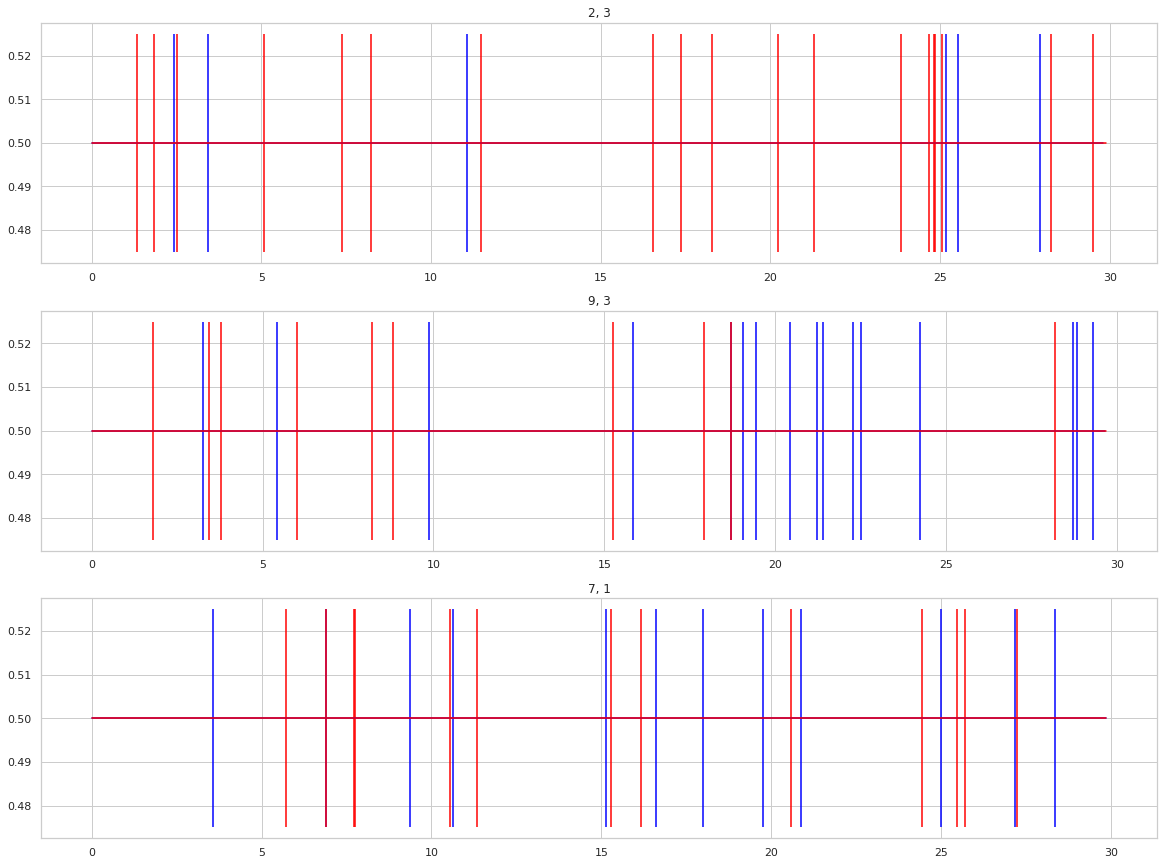

CPU times: user 2.84 s, sys: 7.08 ms, total: 2.85 s
Wall time: 2.85 s


(1440658, 70436, 12676, 174937.5, 6.369192099211643e-05)

In [740]:
%%time
from math import floor, ceil

def rate_lambda(t, ind):
    i, j, is_pos = ind
    frame_ind = min(floor(t / frame_dt), n_frames - 1)
    prev_frame_ind = max(frame_ind - 1, 0)
    pixel_diff = images[frame_ind][i][j] - images[prev_frame_ind][i][j]
    
    if (pixel_diff > pixel_diff_eps and is_pos) or (pixel_diff < -pixel_diff_eps and not is_pos):
        return black_rate + white_rate * abs(pixel_diff)
    else:
        return base_rate

def save_events(ind, t, rate, is_spike):
    i, j, is_pos = ind
    k = int(is_pos)
    ts[i][j][k].append(t)
    rates[i][j][k].append(rate)
    if is_spike:
        spikes[i][j][k].append(t)
        
def recalculate_neuron_state(ind, t, is_spike):
    rate = rate_lambda(t, ind)
    save_events(ind, t, rate, is_spike)
    
    next_spike_dt = sample_spike_dt(t, rate)
    next_spike_t = t + min(next_spike_dt, max_no_fire_dt)
    will_spike = next_spike_dt < max_no_fire_dt

    return next_spike_t, will_spike

unit_of_time = .05   # fraction of second
fpu = 4. # frames per unit of time
t, t_end = 0., 30.
n_frames = int(fpu * t_end)
black_rate, white_rate = .5, 16.
width, height = 20, 20
images = get_images(n_frames, step=2, shape='star', size=(width, height))
T0 = time.monotonic()
frame_dt = t_end / n_frames
max_no_fire_dt = frame_dt * 1.5
pixel_diff_eps = 1./256

pq_times = []
ts, rates, spikes = [make_md_list(list, width, height, 2) for _ in range(3)]
for i in range(width):
    for j in range(height):
        for is_pos in [False, True]:
            ind = (i, j, is_pos)
            next_spike_t, is_spike = recalculate_neuron_state(ind, t, is_spike=False)
            heappush(pq_times, (next_spike_t, is_spike, ind))

free_spin_count = 0
next_spike_t, is_spike, ind = pq_times[0]
while t <= t_end:
    t = scaled_time(T0, time.monotonic())
    if t < next_spike_t:
        free_spin_count += 1
        continue
    
    heappop(pq_times)
    next_spike_t, is_spike = recalculate_neuron_state(ind, t, is_spike)
    heappush(pq_times, (next_spike_t, is_spike, ind))
    
    next_spike_t, is_spike, ind = pq_times[0]

fig, axes = plt.subplots(3, 1, figsize=(20, 15))

for ax in axes:
    x, y = np.random.randint(0, 10, size=(2,))
    min_rates, max_rates = min(min(rates[x][y])), max(max(rates[x][y]))
    for z, color in enumerate(['blue', 'red']):
        sns.lineplot(np.array(ts[x][y][z]), np.array(rates[x][y][z]), ax=ax, color=color)        
        ax.vlines(spikes[x][y][z], min_rates * .95, max_rates * 1.05, colors=color)

    ax.set_title(f"{x}, {y}")

plt.show()
event_count = sum(map(len, iterate_flatten_dims(ts, 2)))
spikes_count = sum(map(len, iterate_flatten_dims(spikes, 2)))
lag_percent = 100 * (lag / event_count) / (event_count / t_end)
free_spin_count, event_count, spikes_count, get_expected_spike_count(), lag_percent